
**Glaucoma Progression Prediction Using UW and GRAPE Visual Fields Data**

Goal: predict glaucoma progression from baseline visual fields

Datasets: UW and GRAPE visual field cohorts

Compare how well the same model works on both


# What We did here?

1. Loaded and explored two independent visual field cohorts: UW (larger value, visit-based) => UW shape: (7428, 19) and GRAPE (smaller value, eye-based) => GRAPE shape: (263, 9) 
2. Inspected raw data structure, column types, and confirmed that visual field sensitivities are stored as arrays/lists per visit
3. Developed a reusable function to transform both datasets into a uniform “long format” (one row = one visit) with individual VF_1 … VF_N columns
4. Standardized visual field point numbering and handled missing/invalid values (-1 dB)
5. Computed Mean Sensitivity (MS) for every visit in both cohorts (ignoring invalid points)
6. Calculated true progression rate (MS_slope in dB/visit) per eye using simple linear regression of MS vs. visit number
7. Excluded eyes with fewer than 2 valid visits to ensure reliable slope estimation
8. Created baseline feature sets: all 54 baseline VF locations + baseline MS for each eye
9. Trained Random Forest Regressors separately on UW and GRAPE to predict continuous MS_slope from baseline features
10. Evaluated in-sample performance (MAE, RMSE, R²) and visualized true vs. predicted slopes for both cohorts
11. Performed cross-dataset generalization tests:
12. UW-trained model => tested on GRAPE (poor transfer) => R²: -1.035
13. GRAPE-trained model => tested on UW (even worse transfer) => R²: -0.103
14. Demonstrated that progression patterns learned from one cohort do not generalize to the other (R² = 0 or negative in cross-tests)
15. Defined clinically meaningful progression classes with literature-based thresholds:
- Stable: > -0.5 dB/visit
- Slow: -0.5 to -1.5 dB/visit
- Fast: < -1.5 dB/visit

Reference: https://pmc.ncbi.nlm.nih.gov/articles/PMC2564806/ 

"In practical terms, these data can be expressed as the time period required to detect MD deterioration of −0.5 dB/year, −1.0 dB/year and −2.0 dB/year with 80% power (table 1) with one, two and three examinations per year. "

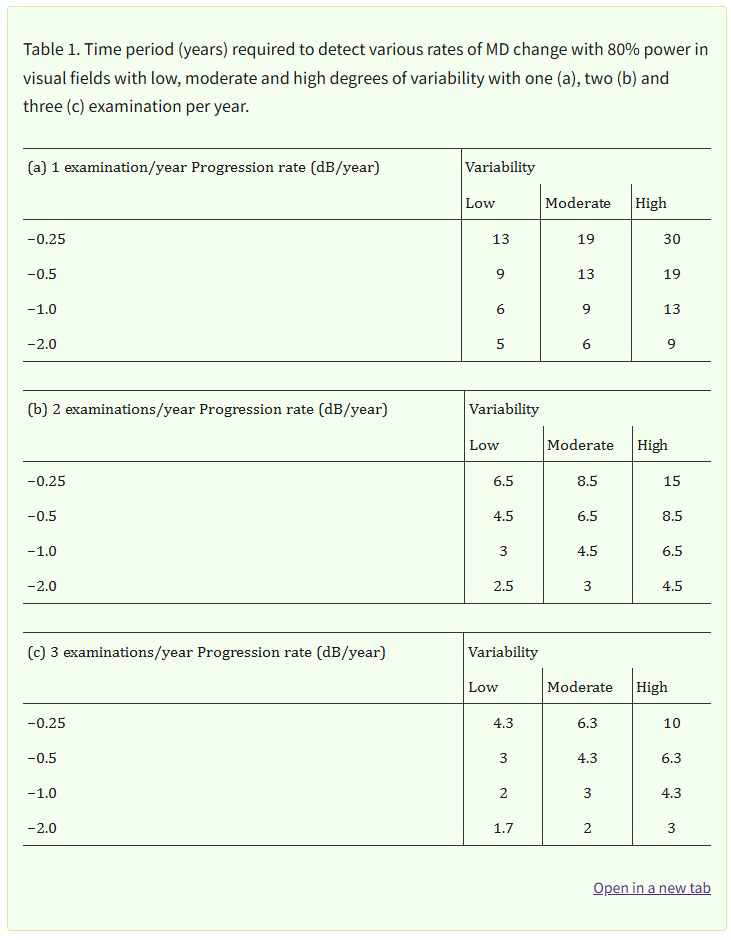

16. Trained simple Random Forest Classifiers using only baseline MS to predict progression category (stable/slow/fast)
17. Visualized classification performance with confusion matrices, class distribution bar plots, and colored baseline MS vs. slope scatter plots for both cohorts



# Cell # 1:

1. Basic imports and plot styling
2. We use pandas/numpy for data handling, sklearn for modeling, and matplotlib for visualization.
3. Setting larger figures and font size for readable plots in the notebook.

In [97]:
# 01
# Importing Open-source libraries:

"""
1. pandas ==> dataframe
2. numpy ==> numerical arrays
3. matpltlib.pyplot ==> plotting
4. scikit-learn ==> predict MS_Slope, mean_absolute_error, mean_squared_error, r2_score

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# For a better visualization, figure sioze = (12, 6) and font size = 14:

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 14


# Cell # 2

1. Load the two visual field cohorts (UW and GRAPE) from pickle files
2. Quick sanity check: print shapes, column names, and first rows to understand the raw structure.

In [ ]:
# 02

"""
1. Loading the visual field datasets (UW and GRAPE) from their pickle files in `uw_path` and `grape_path`. 
2. shape of each dataset to see how many rows (eyes or visits) and columns they contain.
UW shape: (7428, 19)
GRAPE shape: (263, 9)

3. Printing the first few rows using .head() to quickly inspection.


"""


# 1)

uw_path = "UW.pkl"
grape_path = "GRAPE.pkl"

uw_df = pd.read_pickle(uw_path)
grape_df = pd.read_pickle(grape_path)

# 2)

print("UW shape:", uw_df.shape)
print("GRAPE shape:", grape_df.shape)

print("\nUW columns:")
print(uw_df.columns.tolist())

print("\nGRAPE columns:")
print(grape_df.columns.tolist())

# 3)

print("\nUW head:")
display(uw_df.head())

print("\nGRAPE head:")
display(grape_df.head(10))


UW shape: (7428, 19)
GRAPE shape: (263, 9)

UW columns:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

GRAPE columns:
[1, 2, 3, 4, 5, 6, 7, 8, 9]

UW head:


Visit Number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ID,,,,,,,,,,,,,,,,,,,
1-OD,"[10, 9, -1, 10, 21, 24, 21, 18, 20, 19, 17, 23...","[19, 20, 22, 20, 19, 24, 22, 24, 25, 23, 17, 2...","[15, 23, 20, 21, 26, 24, 26, 28, 26, 25, 19, 2...","[13, 16, 11, 6, 5, 22, 24, 20, 23, 23, 18, 23,...","[21, 19, 19, 14, 19, 24, 23, 17, 21, 22, 17, 2...","[23, 21, 18, 20, 23, 26, 24, 22, 24, 22, 18, 2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-OS,"[-1, 17, -1, -1, 19, 23, 18, 18, 25, 20, 18, 2...","[11, -1, 8, -1, 10, 17, 20, 19, 21, 25, 16, 22...","[11, 9, -1, 10, 22, 23, 21, 10, 23, 18, 19, 24...","[7, -1, 3, -1, 15, 21, 14, 15, 18, 15, 15, 22,...","[9, 10, -1, 16, 19, 22, 23, 18, 23, 21, 11, 24...","[16, 17, 16, 20, 17, 16, 21, 21, 23, 24, 21, 2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000-OD,"[23, 23, 23, 20, 25, 26, 24, 19, 22, 16, 25, 2...","[27, 26, 21, 24, 28, 28, 25, 21, 21, 21, 28, 2...","[23, 18, 17, 21, 24, 26, 24, 21, 20, 19, 23, 2...","[19, 20, 16, 22, 29, 24, 26, 24, 13, 10, 22, 2...","[21, 13, 10, 15, 23, 21, 14, 17, 16, 15, 5, 21...","[12, 14, 8, 10, 11, 16, 16, 11, 16, 11, 12, 12...","[2, 4, 5, 9, 2, 13, 19, 13, 13, 13, 13, 17, 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000-OS,"[16, 21, 15, 16, 19, 11, -1, 19, 6, 17, 19, 23...","[4, 22, 21, 20, 1, 11, 18, 20, 24, 21, 12, 24,...","[-1, 5, 15, 18, 11, 23, 18, 21, 15, 15, 20, 25...","[18, 17, 13, -1, 9, 12, 15, 8, 19, 18, 11, 17,...","[-1, 15, 21, 12, 13, 6, 8, 7, 16, 22, 16, 26, ...","[14, 13, 16, 9, 15, 20, 14, -1, 16, 18, 13, 21...","[3, 13, 7, 7, -1, 11, 5, 7, 16, 16, 12, 20, 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002-OD,"[29, 26, 26, 27, 28, 29, 31, 27, 28, 26, 31, 3...","[25, 25, 24, 24, 23, 26, 26, 24, 25, 28, 23, 2...","[-1, 1, 6, 4, 5, 22, -1, 3, 5, 4, 4, 7, 26, 11...","[20, 21, 22, 18, 20, 25, 24, 24, 25, 25, 23, 2...","[23, 23, 22, 24, 22, 27, 26, 25, 27, 23, 24, 2...","[20, 20, 19, 19, 21, 21, 24, 24, 24, 25, 24, 2...","[24, 23, 24, 22, 22, 24, 24, 26, 26, 24, 27, 2...","[22, 24, 22, 26, 26, 27, 27, 29, 29, 27, 31, 2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



GRAPE head:


Visit Number,1,2,3,4,5,6,7,8,9
ID,,,,,,,,,
1-OD,"[21, 22, 20, 23, 24, 25, 14, 25, 25, 20, 18, 2...","[31, 28, 28, 29, 28, 27, 28, 30, 28, 24, 23, 2...","[26, 25, 26, 27, 26, 25, 22, 28, 25, 26, 23, 2...",NaN,NaN,NaN,NaN,NaN,NaN
1-OS,"[24, 26, 23, 26, 26, 27, 23, 26, 28, 26, 24, 2...","[30, 27, 27, 27, 27, 26, 27, 27, 27, 24, 23, 2...","[31, 29, 27, 28, 28, 28, 27, 28, 27, 28, 25, 2...","[29, 32, 24, 26, 29, 30, 27, 20, 31, 31, 24, 2...",NaN,NaN,NaN,NaN,NaN
10-OD,"[31, 30, 29, 29, 29, 30, 28, 30, 29, 29, 29, 2...","[26, 28, 28, 27, 28, 29, 26, 26, 29, 31, 27, 2...","[30, 29, 28, 26, 27, 31, 27, 28, 21, 31, 25, 2...","[28, 27, 22, 24, 27, 29, 19, 22, 28, 27, 24, 2...",NaN,NaN,NaN,NaN,NaN
10-OS,"[32, 31, 29, 30, 30, 29, 30, 31, 29, 28, 25, 2...","[30, 30, 29, 28, 30, 30, 28, 27, 29, 29, 28, 2...","[20, 21, 21, 25, 21, 16, 28, 19, 28, 20, 22, 2...","[29, 30, 23, 25, 27, 28, 27, 18, 29, 25, 24, 2...",NaN,NaN,NaN,NaN,NaN
100-OD,"[29, 32, 29, 30, 16, 26, 26, 25, 24, 27, 25, 2...","[31, 29, 27, 25, 27, 28, 31, 19, 28, 28, 27, 2...","[25, 28, 29, 23, 26, 26, 25, 23, 25, 23, 15, 2...","[23, 26, 24, 21, 24, 27, 28, 13, 27, 27, 26, 2...","[31, 28, 30, 27, 27, 26, 31, 26, 24, 24, 24, 2...",NaN,NaN,NaN,NaN
100-OS,"[25, 27, 25, 24, 27, 27, 24, 23, 26, 30, 27, 2...","[32, 31, 29, 29, 30, 28, 29, 27, 29, 28, 26, 2...","[32, 31, 28, 28, 30, 28, 28, 28, 28, 28, 25, 2...","[30, 27, 23, 24, 29, 28, 17, 27, 27, 26, 23, 2...","[20, 23, 17, 18, 23, 25, 14, 15, 26, 23, 22, 2...",NaN,NaN,NaN,NaN
101-OD,"[23, 31, 10, 12, 34, 26, 6, 18, 25, 23, 12, 18...","[25, 30, 7, 21, 29, 24, 10, 9, 29, 23, 12, 15,...","[21, 29, 5, 6, 28, 23, 5, 5, 23, 19, 9, 16, 2,...","[21, 33, 9, 8, 29, 24, 15, 5, 24, 22, 13, 19, ...","[22, 32, 12, 9, 29, 23, 18, 5, 24, 20, 8, 13, ...","[22, 23, 3, 21, 23, 15, 11, 14, 25, 17, 16, 16...","[18, 24, 5, 20, 26, 22, 4, 16, 23, 19, 8, 14, ...",NaN,NaN
101-OS,"[26, 28, 26, 27, 27, 29, 25, 26, 27, 28, 27, 3...","[33, 32, 30, 27, 31, 30, 29, 27, 29, 33, 28, 2...","[30, 31, 29, 25, 28, 29, 31, 18, 30, 29, 27, 2...","[33, 30, 28, 28, 30, 29, 29, 28, 28, 29, 27, 2...","[33, 31, 27, 28, 29, 29, 27, 29, 27, 29, 26, 2...","[33, 31, 28, 28, 30, 29, 29, 28, 28, 29, 26, 2...","[32, 30, 28, 30, 29, 28, 29, 27, 27, 25, 25, 2...",NaN,NaN
102-OS,"[10, 20, 11, 8, 5, 17, 15, 13, 2, 16, 16, 14, ...","[17, 8, 27, 20, 2, 7, 27, 13, 4, 9, 8, 8, 15, ...","[19, 12, 12, 28, 11, 10, 19, 18, 16, 8, 9, 12,...",NaN,NaN,NaN,NaN,NaN,NaN


# Cell # 03

1. Double-check data types and peek at a few rows
2. Confirming that columns are integers (visit numbers) and that each cell contains a list/array of VF sensitivities.

In [ ]:
# 03

# Quick inspection:

print("UW columns type:", type(uw_df.columns[0]))
print("UW head:")
display(uw_df.head(2))
print("\nGRAPE head:")
display(grape_df.head(10))

UW columns type: <class 'numpy.int64'>
UW head:


Visit Number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ID,,,,,,,,,,,,,,,,,,,
1-OD,"[10, 9, -1, 10, 21, 24, 21, 18, 20, 19, 17, 23...","[19, 20, 22, 20, 19, 24, 22, 24, 25, 23, 17, 2...","[15, 23, 20, 21, 26, 24, 26, 28, 26, 25, 19, 2...","[13, 16, 11, 6, 5, 22, 24, 20, 23, 23, 18, 23,...","[21, 19, 19, 14, 19, 24, 23, 17, 21, 22, 17, 2...","[23, 21, 18, 20, 23, 26, 24, 22, 24, 22, 18, 2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-OS,"[-1, 17, -1, -1, 19, 23, 18, 18, 25, 20, 18, 2...","[11, -1, 8, -1, 10, 17, 20, 19, 21, 25, 16, 22...","[11, 9, -1, 10, 22, 23, 21, 10, 23, 18, 19, 24...","[7, -1, 3, -1, 15, 21, 14, 15, 18, 15, 15, 22,...","[9, 10, -1, 16, 19, 22, 23, 18, 23, 21, 11, 24...","[16, 17, 16, 20, 17, 16, 21, 21, 23, 24, 21, 2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



GRAPE head:


Visit Number,1,2,3,4,5,6,7,8,9
ID,,,,,,,,,
1-OD,"[21, 22, 20, 23, 24, 25, 14, 25, 25, 20, 18, 2...","[31, 28, 28, 29, 28, 27, 28, 30, 28, 24, 23, 2...","[26, 25, 26, 27, 26, 25, 22, 28, 25, 26, 23, 2...",NaN,NaN,NaN,NaN,NaN,NaN
1-OS,"[24, 26, 23, 26, 26, 27, 23, 26, 28, 26, 24, 2...","[30, 27, 27, 27, 27, 26, 27, 27, 27, 24, 23, 2...","[31, 29, 27, 28, 28, 28, 27, 28, 27, 28, 25, 2...","[29, 32, 24, 26, 29, 30, 27, 20, 31, 31, 24, 2...",NaN,NaN,NaN,NaN,NaN
10-OD,"[31, 30, 29, 29, 29, 30, 28, 30, 29, 29, 29, 2...","[26, 28, 28, 27, 28, 29, 26, 26, 29, 31, 27, 2...","[30, 29, 28, 26, 27, 31, 27, 28, 21, 31, 25, 2...","[28, 27, 22, 24, 27, 29, 19, 22, 28, 27, 24, 2...",NaN,NaN,NaN,NaN,NaN
10-OS,"[32, 31, 29, 30, 30, 29, 30, 31, 29, 28, 25, 2...","[30, 30, 29, 28, 30, 30, 28, 27, 29, 29, 28, 2...","[20, 21, 21, 25, 21, 16, 28, 19, 28, 20, 22, 2...","[29, 30, 23, 25, 27, 28, 27, 18, 29, 25, 24, 2...",NaN,NaN,NaN,NaN,NaN
100-OD,"[29, 32, 29, 30, 16, 26, 26, 25, 24, 27, 25, 2...","[31, 29, 27, 25, 27, 28, 31, 19, 28, 28, 27, 2...","[25, 28, 29, 23, 26, 26, 25, 23, 25, 23, 15, 2...","[23, 26, 24, 21, 24, 27, 28, 13, 27, 27, 26, 2...","[31, 28, 30, 27, 27, 26, 31, 26, 24, 24, 24, 2...",NaN,NaN,NaN,NaN
100-OS,"[25, 27, 25, 24, 27, 27, 24, 23, 26, 30, 27, 2...","[32, 31, 29, 29, 30, 28, 29, 27, 29, 28, 26, 2...","[32, 31, 28, 28, 30, 28, 28, 28, 28, 28, 25, 2...","[30, 27, 23, 24, 29, 28, 17, 27, 27, 26, 23, 2...","[20, 23, 17, 18, 23, 25, 14, 15, 26, 23, 22, 2...",NaN,NaN,NaN,NaN
101-OD,"[23, 31, 10, 12, 34, 26, 6, 18, 25, 23, 12, 18...","[25, 30, 7, 21, 29, 24, 10, 9, 29, 23, 12, 15,...","[21, 29, 5, 6, 28, 23, 5, 5, 23, 19, 9, 16, 2,...","[21, 33, 9, 8, 29, 24, 15, 5, 24, 22, 13, 19, ...","[22, 32, 12, 9, 29, 23, 18, 5, 24, 20, 8, 13, ...","[22, 23, 3, 21, 23, 15, 11, 14, 25, 17, 16, 16...","[18, 24, 5, 20, 26, 22, 4, 16, 23, 19, 8, 14, ...",NaN,NaN
101-OS,"[26, 28, 26, 27, 27, 29, 25, 26, 27, 28, 27, 3...","[33, 32, 30, 27, 31, 30, 29, 27, 29, 33, 28, 2...","[30, 31, 29, 25, 28, 29, 31, 18, 30, 29, 27, 2...","[33, 30, 28, 28, 30, 29, 29, 28, 28, 29, 27, 2...","[33, 31, 27, 28, 29, 29, 27, 29, 27, 29, 26, 2...","[33, 31, 28, 28, 30, 29, 29, 28, 28, 29, 26, 2...","[32, 30, 28, 30, 29, 28, 29, 27, 27, 25, 25, 2...",NaN,NaN
102-OS,"[10, 20, 11, 8, 5, 17, 15, 13, 2, 16, 16, 14, ...","[17, 8, 27, 20, 2, 7, 27, 13, 4, 9, 8, 8, 15, ...","[19, 12, 12, 28, 11, 10, 19, 18, 16, 8, 9, 12,...",NaN,NaN,NaN,NaN,NaN,NaN


# Cell # 04

1. Understanding the original layout
2. UW: one row = one visit (already long format)
3. GRAPE: one row = one eye, columns = visits containing VF arrays → needs reshaping

In [ ]:
# 04

# Understand the data structure

# UW: Each row is a visit, columns are integer indices for VF points
# GRAPE: Each row is a patient-eye, columns are visit numbers containing VF arrays

print("UW structure: rows are visits, columns likely include VF fields + MS + MS_slope")
print("UW columns:", list(uw_df.columns))
print("\nGRAPE structure: rows are patient-eyes, columns are visit numbers")
print("GRAPE columns:", list(grape_df.columns))

print("\nUW sample row:")
display(uw_df.iloc[0])


UW structure: rows are visits, columns likely include VF fields + MS + MS_slope
UW columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

GRAPE structure: rows are patient-eyes, columns are visit numbers
GRAPE columns: [1, 2, 3, 4, 5, 6, 7, 8, 9]

UW sample row:


Visit Number
1     [10, 9, -1, 10, 21, 24, 21, 18, 20, 19, 17, 23...
2     [19, 20, 22, 20, 19, 24, 22, 24, 25, 23, 17, 2...
3     [15, 23, 20, 21, 26, 24, 26, 28, 26, 25, 19, 2...
4     [13, 16, 11, 6, 5, 22, 24, 20, 23, 23, 18, 23,...
5     [21, 19, 19, 14, 19, 24, 23, 17, 21, 22, 17, 2...
6     [23, 21, 18, 20, 23, 26, 24, 22, 24, 22, 18, 2...
7                                                   NaN
8                                                   NaN
9                                                   NaN
10                                                  NaN
11                                                  NaN
12                                                  NaN
13                                                  NaN
14                                                  NaN
15                                                  NaN
16                                                  NaN
17                                                  NaN
18                                 

# Cell 05

1. Convert both datasets to a uniform "long" format: one row per visit
2. This function explodes the eye × visit tables so every visit gets its own row with VF_1 … VF_N columns.
3. Essential for consistent downstream processing.

In [ ]:
# 05

# Transform data ==> UW and GRAPE

def transform_df_to_visits(df):
    """
    Transform the pkl format (rows=eyes, cols=visits with VF arrays)
    into a long format (one row per visit with VF features).
    """
    rows = []
    for eye_id in df.index:
        for visit_num in df.columns:
            vf_data = df.loc[eye_id, visit_num]

            # If the cell doesn't contain a VF array ("NaN"), skip it:

            if not isinstance(vf_data, (list, np.ndarray)):
                continue

            # Starts a new row: stores which eye it belongs to and which visit number it is:
            row_dict = {"eye_id": eye_id, "visit_num": visit_num}

            #Loops through the VF sensitivity list and creates a separate column for each VF point (VF_1, VF_2, …):

            for i, val in enumerate(vf_data):
                row_dict[f"VF_{i+1}"] = val
            rows.append(row_dict)

    # Converting all collected rows into a new DataFrame where each row is a visit:

    return pd.DataFrame(rows)

# Runs the transformation on the UW dataset and prints how many visits were created:

print("Transforming UW data")
uw_visits = transform_df_to_visits(uw_df)
print(f"UW: {len(uw_df)} eyes -> {len(uw_visits)} visits")
display(uw_visits.head(10))


# Runs the transformation on the GRAPE dataset and prints how many visits were created:

print("\nTransforming GRAPE data")
grape_visits = transform_df_to_visits(grape_df)
print(f"GRAPE: {len(grape_df)} eyes -> {len(grape_visits)} visits")
display(grape_visits.head(10))

Transforming UW data
UW: 7428 eyes -> 28943 visits


,eye_id,visit_num,VF_1,VF_2,VF_3,VF_4,VF_5,VF_6,VF_7,VF_8,...,VF_45,VF_46,VF_47,VF_48,VF_49,VF_50,VF_51,VF_52,VF_53,VF_54
0,1-OD,1,10,9,-1,10,21,24,21,18,...,22,28,26,26,26,26,19,17,23,26
1,1-OD,2,19,20,22,20,19,24,22,24,...,25,27,25,26,25,25,24,23,25,23
2,1-OD,3,15,23,20,21,26,24,26,28,...,26,24,26,29,30,29,20,24,22,23
3,1-OD,4,13,16,11,6,5,22,24,20,...,18,28,29,26,27,29,22,24,26,26
4,1-OD,5,21,19,19,14,19,24,23,17,...,26,27,26,26,28,27,24,26,26,27
5,1-OD,6,23,21,18,20,23,26,24,22,...,26,26,28,29,29,28,25,27,27,27
6,1-OS,1,-1,17,-1,-1,19,23,18,18,...,26,25,27,26,28,26,20,21,24,26
7,1-OS,2,11,-1,8,-1,10,17,20,19,...,29,26,27,29,28,27,22,27,27,24
8,1-OS,3,11,9,-1,10,22,23,21,10,...,19,24,24,24,26,26,20,22,23,19
9,1-OS,4,7,-1,3,-1,15,21,14,15,...,21,22,22,22,25,22,21,17,17,25



Transforming GRAPE data
GRAPE: 263 eyes -> 1115 visits


,eye_id,visit_num,VF_1,VF_2,VF_3,VF_4,VF_5,VF_6,VF_7,VF_8,...,VF_51,VF_52,VF_53,VF_54,VF_55,VF_56,VF_57,VF_58,VF_59,VF_60
0,1-OD,1,21,22,20,23,24,25,14,25,...,20,22,21,23,26,14,13,19,20,21
1,1-OD,2,31,28,28,29,28,27,28,30,...,20,22,17,22,16,12,14,21,21,18
2,1-OD,3,26,25,26,27,26,25,22,28,...,20,19,12,20,12,5,20,22,25,22
3,1-OS,1,24,26,23,26,26,27,23,26,...,21,22,21,21,21,23,25,22,25,22
4,1-OS,2,30,27,27,27,27,26,27,27,...,27,23,20,22,22,21,20,21,24,25
5,1-OS,3,31,29,27,28,28,28,27,28,...,28,23,21,23,22,24,14,24,27,25
6,1-OS,4,29,32,24,26,29,30,27,20,...,26,24,17,24,21,23,13,25,24,24
7,10-OD,1,31,30,29,29,29,30,28,30,...,28,27,23,24,26,26,26,17,18,25
8,10-OD,2,26,28,28,27,28,29,26,26,...,25,28,25,23,23,25,23,25,16,27
9,10-OD,3,30,29,28,26,27,31,27,28,...,22,26,27,21,23,23,23,22,22,23


# Cell # 06

1. Compute Mean Sensitivity (MS) for every visit and then calculate MS slope per eye (UW cohort)
2. MS = average of valid (≠ -1) threshold values.
3. Linear regression of MS vs visit number → slope = progression rate in dB/visit.
4. We keep only eyes with ≥2 valid visits and store baseline VF + baseline MS as features.

In [ ]:
# 06

#Computing MS and slopes for UW


# Collects all the visual-field columns (VF_1, VF_2, …):

vf_cols = [c for c in uw_visits.columns if c.startswith("VF_")]

# Shows how many VF locations each test has:

print(f"Found {len(vf_cols)} VF points in UW dataset")

# Defines a function that takes one visit and calculates the average sensitivity, ignoring invalid values (–1):

def compute_ms(row):
    vals = row[vf_cols].values
    valid = vals[vals != -1]
    return valid.mean() if len(valid) > 0 else np.nan



# Adds a new column “MS” to every visit in the UW dataset:

uw_visits["MS"] = uw_visits.apply(compute_ms, axis=1)

# Compute slope per eye
uw_slopes = []
for eye_id in uw_visits["eye_id"].unique():

    # Gets all visits for that eye and orders them by visit number:

    eye_data = uw_visits[uw_visits["eye_id"] == eye_id].sort_values("visit_num")

    eye_data = eye_data.dropna(subset=["MS"])  # Drop visits with no valid MS
    

    # If an eye has fewer than two visits, skip it (no slope possible, we need to have atleast 2 visits):

    if len(eye_data) < 2:
        continue
    
    # Prepares visit numbers and MS values for regression:

    X = eye_data["visit_num"].values.reshape(-1, 1)
    y = eye_data["MS"].values
    

    # Fits a simple linear regression and extracts the slope (progression rate):

    reg = LinearRegression().fit(X, y)
    slope = reg.coef_[0]
    
    #The first visit for this eye:

    baseline = eye_data.iloc[0]

    # Creates a dictionary storing the eye ID, progression slope, and baseline MS:

    row_dict = {"eye_id": eye_id, "MS_slope": slope, "baseline_MS": baseline["MS"]}
    for col in vf_cols:
        row_dict[f"baseline_{col}"] = baseline[col]
    uw_slopes.append(row_dict)

# Creates a dataset where each row is one eye, with baseline features and its slope:

uw_slopes_df = pd.DataFrame(uw_slopes)


# Shows how many eyes were processed: 

print(f"UW slopes computed for {len(uw_slopes_df)} eyes")
display(uw_slopes_df.head(10))

Found 54 VF points in UW dataset
UW slopes computed for 7393 eyes


,eye_id,MS_slope,baseline_MS,baseline_VF_1,baseline_VF_2,baseline_VF_3,baseline_VF_4,baseline_VF_5,baseline_VF_6,baseline_VF_7,...,baseline_VF_45,baseline_VF_46,baseline_VF_47,baseline_VF_48,baseline_VF_49,baseline_VF_50,baseline_VF_51,baseline_VF_52,baseline_VF_53,baseline_VF_54
0,1-OD,0.614745,21.905660,10,9,-1,10,21,24,21,...,22,28,26,26,26,26,19,17,23,26
1,1-OS,-0.529574,24.568627,-1,17,-1,-1,19,23,18,...,26,25,27,26,28,26,20,21,24,26
2,1000-OD,-1.856608,24.566038,23,23,23,20,25,26,24,...,24,24,26,24,25,27,22,21,24,24
3,1000-OS,-1.501548,21.692308,16,21,15,16,19,11,-1,...,22,20,20,21,21,18,17,19,18,18
4,1002-OD,0.350370,29.641509,29,26,26,27,28,29,31,...,28,31,31,31,31,30,23,27,24,29
5,1002-OS,0.003819,30.245283,25,32,27,29,28,29,30,...,27,33,31,30,32,31,28,26,30,30
6,1005-OD,1.198463,25.518519,25,27,21,18,30,30,27,...,23,28,24,22,27,25,22,22,22,22
7,1005-OS,-1.193920,25.471698,12,19,20,25,15,23,23,...,26,26,25,27,25,29,24,24,23,26
8,1007-OD,0.162788,32.055556,31,32,33,32,34,29,30,...,32,33,34,32,33,33,33,32,32,34
9,1007-OS,0.247275,32.351852,32,33,33,34,34,32,34,...,33,33,33,32,32,32,32,34,33,34


# Cell # 07

1. Same MS and slope computation but now for the smaller GRAPE cohort
2. Using identical code so the two datasets are processed exactly the same way.

In [ ]:
# 07

# Computing MS and slopes for GRAPE


# Computes the mean sensitivity (MS) for every GRAPE visit using the same function used for UW dataset:

grape_visits["MS"] = grape_visits.apply(compute_ms, axis=1)


# Compute slope per eye
grape_slopes = []

# Loops through each eye in the GRAPE dataset:

for eye_id in grape_visits["eye_id"].unique():

    # Gets all visits for this eye and orders them by visit number:

    eye_data = grape_visits[grape_visits["eye_id"] == eye_id].sort_values("visit_num")

    # Removes visits where MS wasn’t calculated:

    eye_data = eye_data.dropna(subset=["MS"])
    

    # Skips eyes with fewer than two visits:

    if len(eye_data) < 2:
        continue
    

    # Prepares the inputs (visit number) and outputs (MS) for regression:

    X = eye_data["visit_num"].values.reshape(-1, 1)
    y = eye_data["MS"].values
    

    # Fits a simple linear model and extracts the MS slope:

    reg = LinearRegression().fit(X, y)
    slope = reg.coef_[0]
    
    # The first visit, used as baseline:

    baseline = eye_data.iloc[0]

    # Stores eye ID, slope, and baseline MS:

    row_dict = {"eye_id": eye_id, "MS_slope": slope, "baseline_MS": baseline["MS"]}

    # Adds all baseline VF points as features:

    for col in vf_cols:
        row_dict[f"baseline_{col}"] = baseline[col]
    grape_slopes.append(row_dict)

# Creates a DataFrame where each row is one eye:

grape_slopes_df = pd.DataFrame(grape_slopes)

# Shows how many eyes were processed:

print(f"GRAPE slopes computed for {len(grape_slopes_df)} eyes.")
display(grape_slopes)

GRAPE slopes computed for 263 eyes.


[{'eye_id': '1-OD',
  'MS_slope': np.float64(0.16037735849056556),
  'baseline_MS': np.float64(19.962264150943398),
  'baseline_VF_1': np.int64(21),
  'baseline_VF_2': np.int64(22),
  'baseline_VF_3': np.int64(20),
  'baseline_VF_4': np.int64(23),
  'baseline_VF_5': np.int64(24),
  'baseline_VF_6': np.int64(25),
  'baseline_VF_7': np.int64(14),
  'baseline_VF_8': np.int64(25),
  'baseline_VF_9': np.int64(25),
  'baseline_VF_10': np.int64(20),
  'baseline_VF_11': np.int64(18),
  'baseline_VF_12': np.int64(21),
  'baseline_VF_13': np.int64(16),
  'baseline_VF_14': np.int64(18),
  'baseline_VF_15': np.int64(18),
  'baseline_VF_16': np.int64(23),
  'baseline_VF_17': np.int64(22),
  'baseline_VF_18': np.int64(23),
  'baseline_VF_19': np.int64(25),
  'baseline_VF_20': np.int64(24),
  'baseline_VF_21': np.int64(26),
  'baseline_VF_22': np.int64(-1),
  'baseline_VF_23': np.int64(14),
  'baseline_VF_24': np.int64(18),
  'baseline_VF_25': np.int64(17),
  'baseline_VF_26': np.int64(14),
  'baseli

# Cell # 08

1. Train a Random Forest Regressor on UW eyes only
2. Features = all 54 baseline VF locations + baseline MS
3. Target = true MS_slope (dB/visit)
4. In-sample performance is shown (expected to be very good because RF can overfit).

In [ ]:
# 08

# Preparing training data and train Random Forest for UW dataset:

# Creates a list of all baseline VF feature names (baseline_VF_1, baseline_VF_2, ...):

baseline_vf_cols = [f"baseline_{c}" for c in vf_cols]

# Adding baseline MS to the feature list:

feature_cols = baseline_vf_cols + ["baseline_MS"]


# Creating the training dataset:
# uw_X = baseline features
# uw_y = the MS slope for prediction

uw_X = uw_slopes_df[feature_cols]
uw_y = uw_slopes_df["MS_slope"]

print(f"Training on {len(uw_X)} UW eyes")
print(f"Features: {len(feature_cols)}")


# Creates a Random Forest model with 500 trees:

rfr = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
)


# Trains the model on the UW dataset:

rfr.fit(uw_X, uw_y)
print("Random Forest trained!")

# In-sample performance
# Predicts slopes for all training eyes:

uw_pred = rfr.predict(uw_X)


print(f"\nUW in-sample performance:")

# Mean absolute error ==> how far predictions are from the true slopes:

print(f"  MAE (Meas Absolute Error): {mean_absolute_error(uw_y, uw_pred):.3f} dB/visit")

# Root mean squared error ==> penalizes large mistakes more:

print(f"  RMSE (Root Meas Square Error): {np.sqrt(mean_squared_error(uw_y, uw_pred)):.3f} dB/visit")

# R² score ==> measures how much of the slope variability the model explains:

print(f"  R squared:   {r2_score(uw_y, uw_pred):.3f}")

Training on 7393 UW eyes
Features: 55
Random Forest trained!

UW in-sample performance:
  MAE (Meas Absolute Error): 0.406 dB/visit
  RMSE (Root Meas Square Error): 0.723 dB/visit
  R squared:   0.871


# Cell # 09

1. Scatter plot of true vs predicted MS slope on UW (in-sample)
2. Points should lie close to the diagonal, just a sanity check that the model learned something.

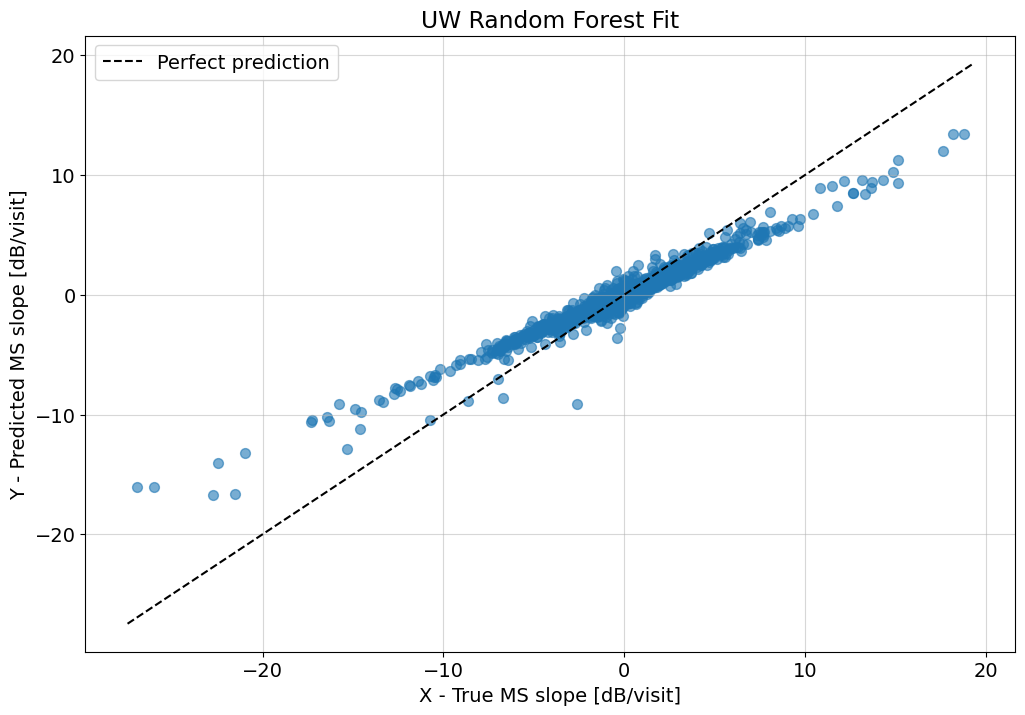

In [ ]:
# 09

# UW Random Forest fit: true vs predicted MS slope

plt.figure(figsize=(12,8))

plt.scatter(uw_y, uw_pred, alpha=0.6, s=50)
lims = [min(uw_y.min(), uw_pred.min()) - 0.5,
        max(uw_y.max(), uw_pred.max()) + 0.5]

plt.plot(lims, lims, "k--", label="Perfect prediction")

plt.xlabel("X - True MS slope [dB/visit]")
plt.ylabel("Y - Predicted MS slope [dB/visit]")

plt.title("UW Random Forest Fit")

plt.grid(True, alpha=0.5)
plt.legend()

plt.show()


This plot shows how well the model fits the UW data when trained and tested on the same eyes. The points cluster around the diagonal,
meaning the model mostly memorizes UW patterns. This is expected for in-sample performance.
The real check is how much accuracy drops when we test the UW model on the GRAPE dataset.

# Cell # 10

1. Train a separate Random Forest Regressor on GRAPE eyes only
2. Same architecture and features as the UW model => fair comparison later.
3. Again, in-sample metrics look decent.

In [ ]:
# 10

# GRAPE: Prepare training data and train Random Forest
# Features: baseline VF values + baseline MS (same structure as UW):

baseline_vf_cols = [f"baseline_{c}" for c in vf_cols]
feature_cols = baseline_vf_cols + ["baseline_MS"]

# Creating the training dataset:
# grape_X = baseline features
# grape_y = the MS slope for prediction

grape_X = grape_slopes_df[feature_cols]
grape_y = grape_slopes_df["MS_slope"]

print(f"Training on {len(grape_X)} GRAPE eyes")
print(f"Features: {len(feature_cols)}")

# Creates a Random Forest model with 500 trees for GRAPE

rfr_grape = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
)

# Trains the model on the GRAPE dataset

rfr_grape.fit(grape_X, grape_y)
print("Random Forest (GRAPE) trained!")

# In-sample performance
# Predicts slopes for all training eyes

grape_pred = rfr_grape.predict(grape_X)

print("\nGRAPE in-sample performance:")

# Mean absolute error ==> how far predictions are from the true slopes

print(f"  MAE (Mean Absolute Error): {mean_absolute_error(grape_y, grape_pred):.3f} dB/visit")

# Root mean squared error ==> penalizes large mistakes more

print(f"  RMSE (Root Mean Square Error): {np.sqrt(mean_squared_error(grape_y, grape_pred)):.3f} dB/visit")

# R² score ==> measures how much of the slope variability the model explains

print(f"  R squared: {r2_score(grape_y, grape_pred):.3f}")


Training on 263 GRAPE eyes
Features: 55
Random Forest (GRAPE) trained!

GRAPE in-sample performance:
  MAE (Mean Absolute Error): 0.255 dB/visit
  RMSE (Root Mean Square Error): 0.355 dB/visit
  R squared: 0.870


# Cell # 11

1. True vs predicted plot for GRAPE in-sample fit
2. Visual confirmation that the GRAPE-trained model also learned the progression patterns in its own data.

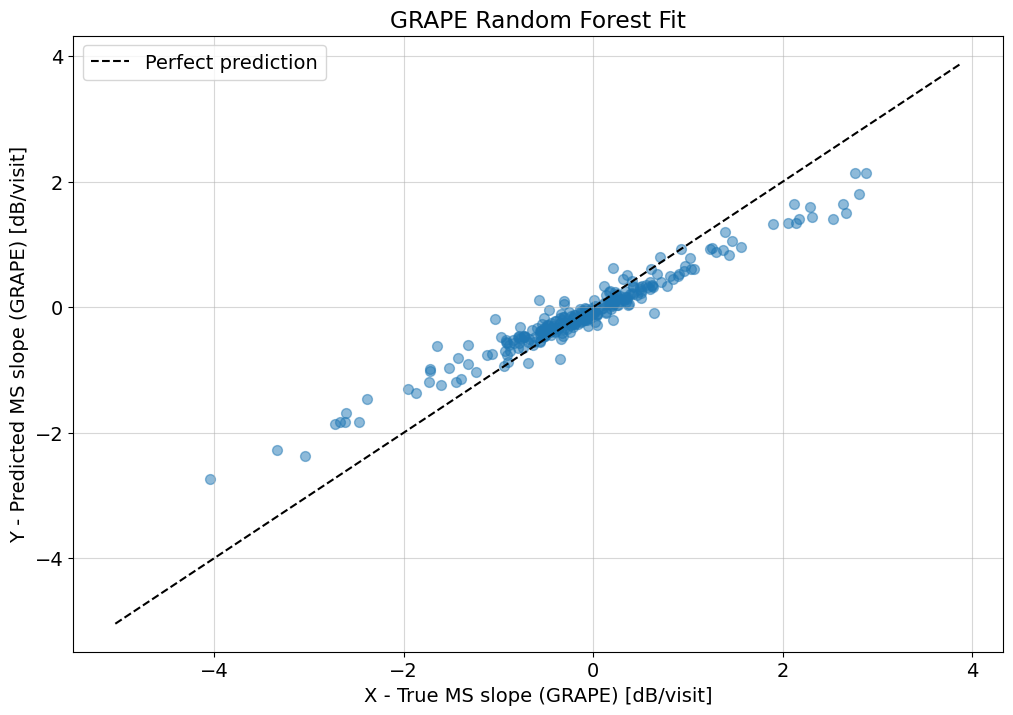

In [ ]:
# 11

# GRAPE Random Forest fit: true vs predicted MS slope

plt.figure(figsize=(12, 8))

plt.scatter(grape_y, grape_pred, alpha=0.5, s=50)
lims = [
    min(grape_y.min(), grape_pred.min()) - 1,
    max(grape_y.max(), grape_pred.max()) + 1,
]


plt.plot(lims, lims, "k--", label="Perfect prediction")


plt.xlabel("X - True MS slope (GRAPE) [dB/visit]")
plt.ylabel("Y - Predicted MS slope (GRAPE) [dB/visit]")

plt.title("GRAPE Random Forest Fit")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()


This plot shows how well the model fits the GRAPE dataset when trained and tested on the same eyes. Most points fall near the diagonal, meaning the model captures the GRAPE progression patterns pretty well. Since this is in-sample performance, it mainly acts as a baseline. The important question is how much this accuracy drops when we test a GRAPE-trained model on UW eyes, or when we test the UW model on GRAPE.

# Cell # 12

1. Cross-dataset test: UW-trained model => GRAPE eyes
2. This is the key generalization experiment. We expect performance to drop if the cohorts differ in population, testing strategy, or noise characteristics.

=== Cross-dataset: UW model on GRAPE (263 eyes) ===
  MAE:  0.975 dB/visit
  RMSE: 1.404 dB/visit
  R²:   -1.035


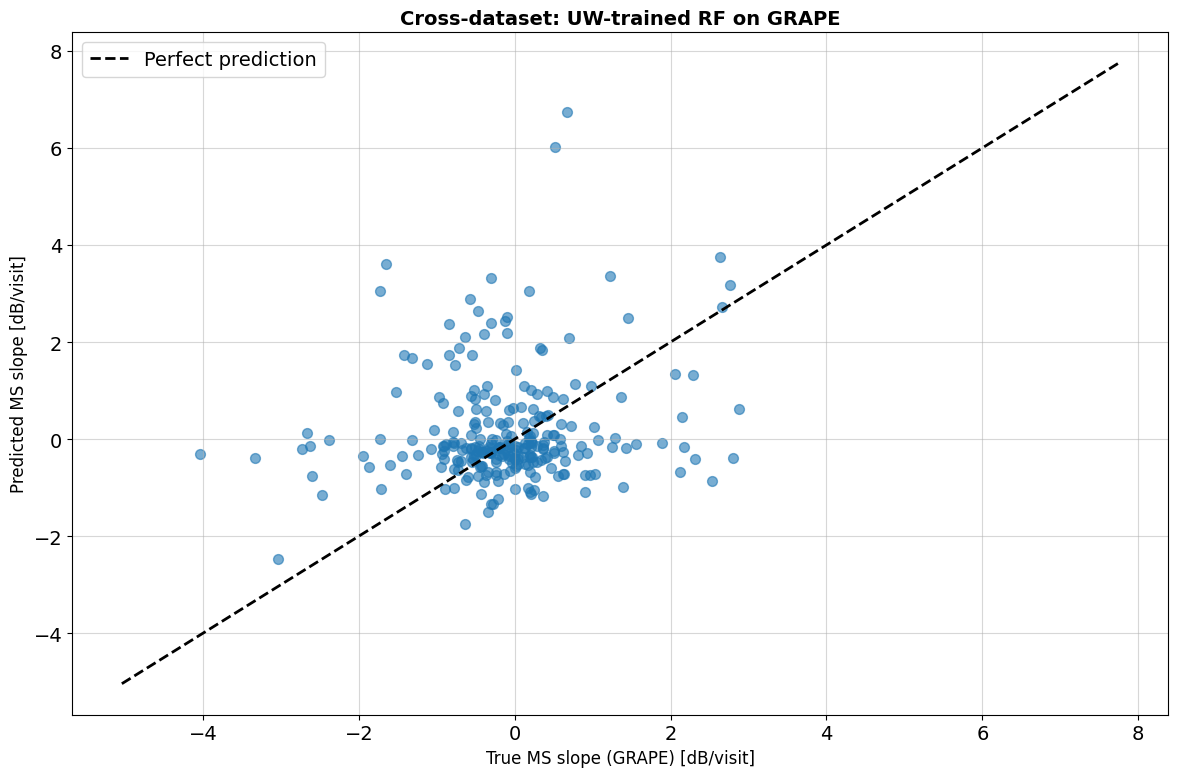

In [ ]:
# 12

# UW Evaluation on GRAPE

grape_X = grape_slopes_df[feature_cols]
grape_y = grape_slopes_df["MS_slope"]

grape_pred = rfr.predict(grape_X)

print(f"=== Cross-dataset: UW model on GRAPE ({len(grape_X)} eyes) ===")
print(f"  MAE:  {mean_absolute_error(grape_y, grape_pred):.3f} dB/visit")
print(f"  RMSE: {np.sqrt(mean_squared_error(grape_y, grape_pred)):.3f} dB/visit")
print(f"  R²:   {r2_score(grape_y, grape_pred):.3f}")

# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(grape_y, grape_pred, alpha=0.6, s=50)
lims = [min(grape_y.min(), grape_pred.min()) - 1, max(grape_y.max(), grape_pred.max()) + 1]
plt.plot(lims, lims, "k--", linewidth=2, label="Perfect prediction")
plt.xlabel("True MS slope (GRAPE) [dB/visit]", fontsize=12)
plt.ylabel("Predicted MS slope [dB/visit]", fontsize=12)
plt.title("Cross-dataset: UW-trained RF on GRAPE", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

The metrics and scatter plot show that the UW model does not transfer well to GRAPE (R² is close to or below zero and points are widely scattered around the diagonal). This means the progression patterns learned from UW eyes do not generalize cleanly to the GRAPE cohort, suggesting differences in population, testing conditions, or noise between the two datasets.

# Cell # 13

1. Reverse cross-dataset test: GRAPE-trained model => UW eyes
2. Usually even worse because GRAPE is much smaller and the model learned on fewer examples.
3. Together with cell 12, this shows poor transferability between the two cohorts.

=== Cross-dataset: GRAPE model on UW (7393 eyes) ===
  MAE:  1.365 dB/visit
  RMSE: 2.120 dB/visit
  R²:   -0.103


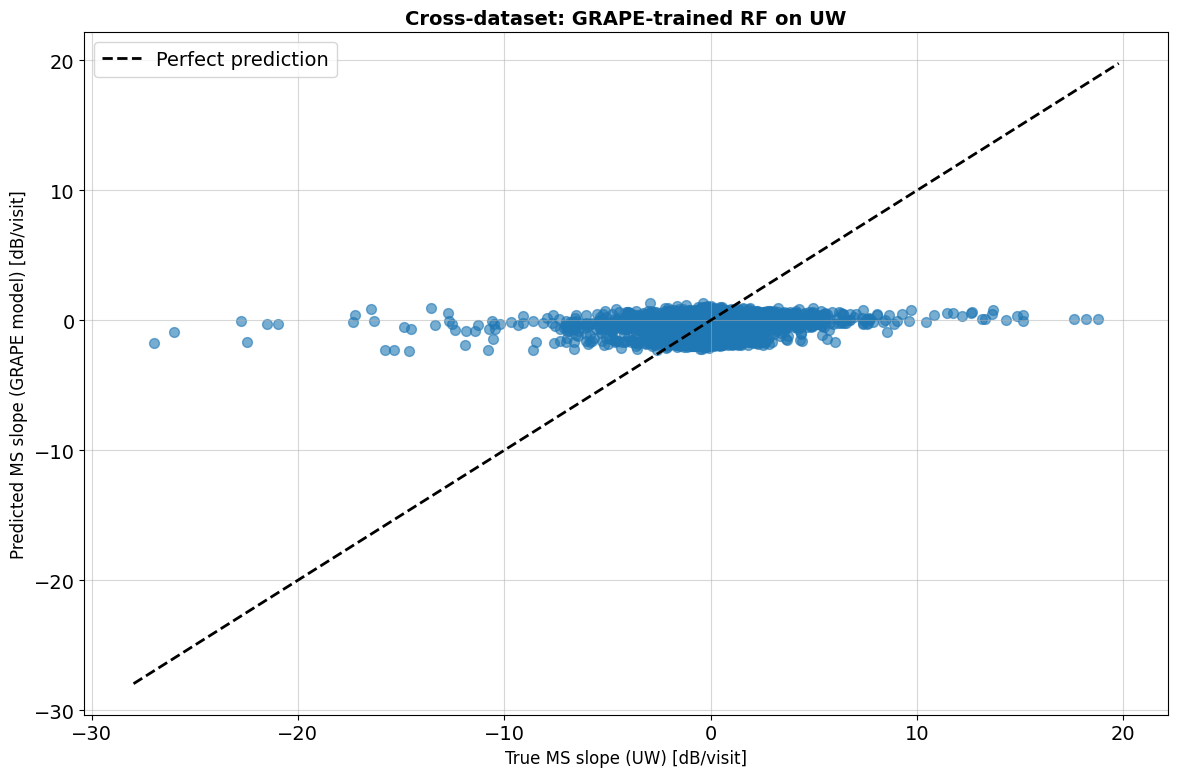

In [ ]:
# 13

# Cross-dataset evaluation — GRAPE-trained model on UW

# Prepare UW test set
uw_X_test = uw_slopes_df[feature_cols]
uw_y_test = uw_slopes_df["MS_slope"]

# Use the GRAPE-trained Random Forest (rfr_grape)
uw_pred_from_grape = rfr_grape.predict(uw_X_test)

print(f"=== Cross-dataset: GRAPE model on UW ({len(uw_X_test)} eyes) ===")
print(f"  MAE:  {mean_absolute_error(uw_y_test, uw_pred_from_grape):.3f} dB/visit")
print(f"  RMSE: {np.sqrt(mean_squared_error(uw_y_test, uw_pred_from_grape)):.3f} dB/visit")
print(f"  R²:   {r2_score(uw_y_test, uw_pred_from_grape):.3f}")

# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(uw_y_test, uw_pred_from_grape, alpha=0.6, s=50)

lims = [
    min(uw_y_test.min(), uw_pred_from_grape.min()) - 1,
    max(uw_y_test.max(), uw_pred_from_grape.max()) + 1,
]

plt.plot(lims, lims, "k--", linewidth=2, label="Perfect prediction")

plt.xlabel("True MS slope (UW) [dB/visit]", fontsize=12)
plt.ylabel("Predicted MS slope (GRAPE model) [dB/visit]", fontsize=12)
plt.title("Cross-dataset: GRAPE-trained RF on UW", fontsize=14, fontweight="bold")

plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


This plot shows how a model trained on GRAPE performs when predicting UW slopes. The points scatter far from the diagonal and the R² value is negative, which means the GRAPE model does not generalize to UW. The GRAPE-trained model tends to predict slopes close to zero for almost all UW eyes, missing both fast progression and fast improvement. Together with the UW => GRAPE results, this suggests that the two datasets capture progression differently, and baseline VF patterns do not transfer well across cohorts.

# Cell # 14


1. Progression classification task (stable / slow / fast)
2. Thresholds chosen based on clinical literature:
#   > -0.5 dB/visit ≈ stable or very slow (common clinical cutoff)
#   -0.5 to -1.5 dB/visit ≈ slow progression
#   < -1.5 dB/visit ≈ fast progression (high risk, often triggers treatment escalation)
3. These cutoffs are widely used in glaucoma trials and clinical practice (e.g., CIGTS, AGIS, EMGT).
4. We then train simple Random Forest classifiers using only baseline MS (for interpretability).

I will add the reference for the cutoffs.

UW + GRAPE classifiers trained!


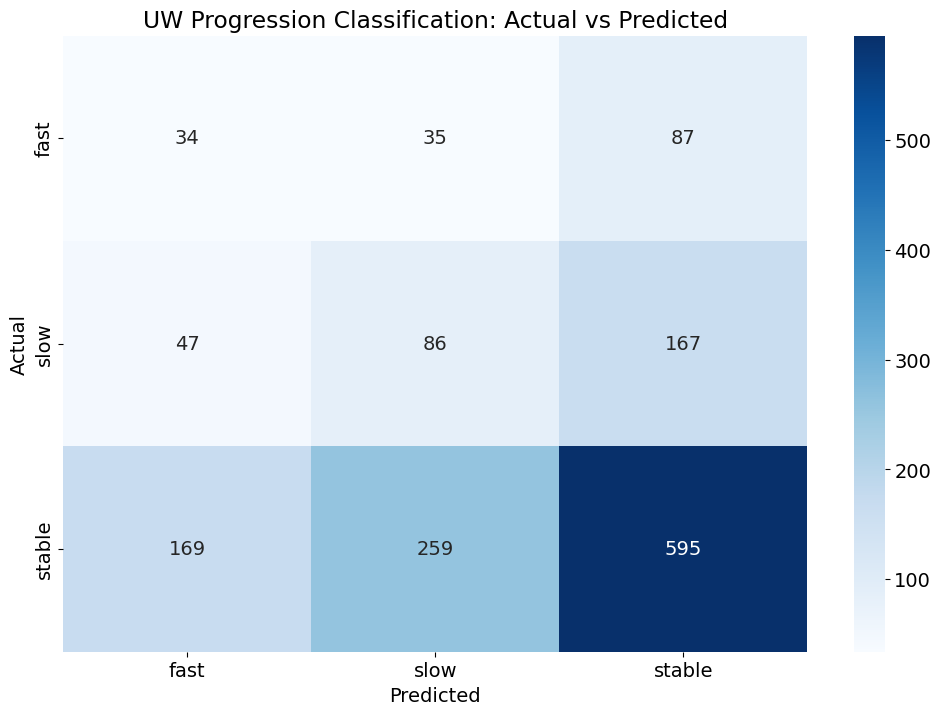

<Figure size 1200x800 with 0 Axes>

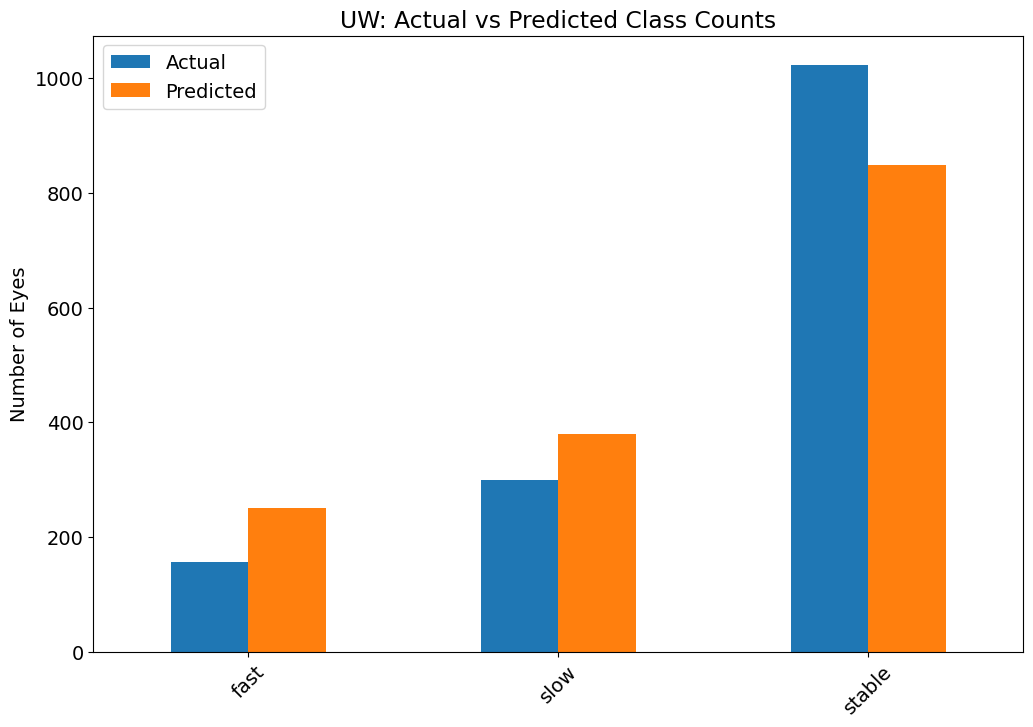

In [96]:
# 14

def classify_slope(slope):
    if slope > -0.5:
        return "stable"
    elif slope > -1.5:
        return "slow"
    else:
        return "fast"

uw_slopes_df["progression_class"] = uw_slopes_df["MS_slope"].apply(classify_slope)
grape_slopes_df["progression_class"] = grape_slopes_df["MS_slope"].apply(classify_slope)



uw_X = uw_slopes_df[["baseline_MS"]]
uw_y = uw_slopes_df["progression_class"]

grape_X = grape_slopes_df[["baseline_MS"]]
grape_y = grape_slopes_df["progression_class"]


from sklearn.model_selection import train_test_split

uw_X_train, uw_X_test, uw_y_train, uw_y_test = train_test_split(
    uw_X, uw_y, test_size=0.2, random_state=42, stratify=uw_y
)

grape_X_train, grape_X_test, grape_y_train, grape_y_test = train_test_split(
    grape_X, grape_y, test_size=0.2, random_state=42, stratify=grape_y
)



from sklearn.ensemble import RandomForestClassifier

clf_uw = RandomForestClassifier(
    n_estimators=300, random_state=42, class_weight="balanced"
)
clf_uw.fit(uw_X_train, uw_y_train)

clf_grape = RandomForestClassifier(
    n_estimators=300, random_state=42, class_weight="balanced"
)
clf_grape.fit(grape_X_train, grape_y_train)

print("UW + GRAPE classifiers trained!")



uw_pred = clf_uw.predict(uw_X_test)
grape_pred = clf_grape.predict(grape_X_test)




import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12,8))
sns.heatmap(
    confusion_matrix(uw_y_test, uw_pred),
    annot=True, fmt="d", cmap="Blues",
    xticklabels=clf_uw.classes_,
    yticklabels=clf_uw.classes_
)
plt.title("UW Progression Classification: Actual vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


plt.figure(figsize=(12, 8))

actual_counts = uw_y_test.value_counts().sort_index()

pred_counts = pd.Series(uw_pred).value_counts().sort_index()

df_counts = pd.DataFrame({

    "Actual": actual_counts,
    "Predicted": pred_counts
})

df_counts.plot(kind="bar", figsize=(12,8))

plt.title("UW: Actual vs Predicted Class Counts")
plt.ylabel("Number of Eyes")

plt.xticks(rotation=45)

plt.show()


# Cell # 15

1. Confusion matrix and class distribution for UW classifier
2. Shows how well (or poorly) baseline MS alone can separate the three progression classes in UW.

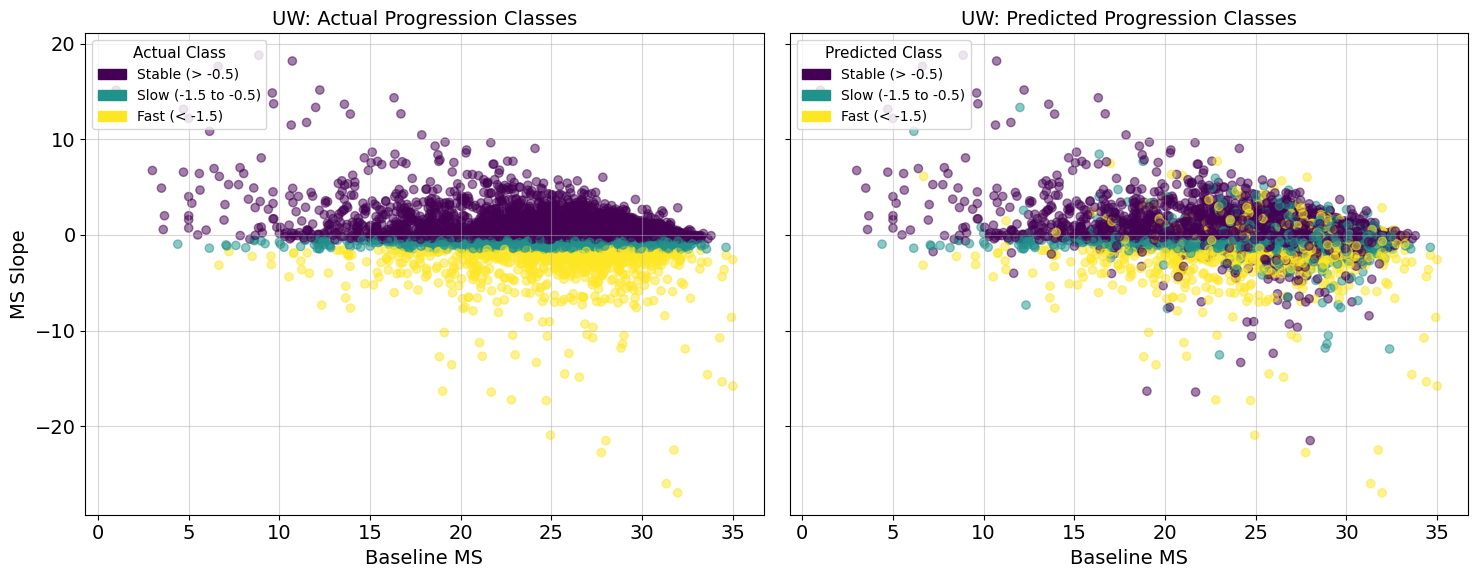

In [ ]:
# 15

# colormap value
class_to_val = {"stable": 0.0, "slow": 0.5, "fast": 1.0}

legend_colors = {
    "stable": plt.cm.viridis(0.0),
    "slow": plt.cm.viridis(0.5),
    "fast": plt.cm.viridis(1.0),
}

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

# Actual Classes:

axes[0].scatter(
    uw_slopes_df["baseline_MS"],
    uw_slopes_df["MS_slope"],
    c=uw_slopes_df["progression_class"].map(class_to_val),
    cmap="viridis",
    alpha=0.5,
)

axes[0].set_title("UW: Actual Progression Classes", fontsize=14)
axes[0].set_xlabel("Baseline MS")
axes[0].set_ylabel("MS Slope")
axes[0].grid(alpha=0.5)

# Legend under left plot:

actual_legend = [
    mpatches.Patch(color=legend_colors["stable"], label="Stable (> -0.5)"),
    mpatches.Patch(color=legend_colors["slow"], label="Slow (-1.5 to -0.5)"),
    mpatches.Patch(color=legend_colors["fast"], label="Fast (< -1.5)"),
]
axes[0].legend(
    handles=actual_legend,
    title="Actual Class",
    loc="upper left",
    fontsize=10,
    title_fontsize=11,
)


# Predicted Classes:

axes[1].scatter(
    uw_slopes_df["baseline_MS"],
    uw_slopes_df["MS_slope"],
    c=uw_slopes_df["predicted_class"].map(class_to_val),
    cmap="viridis",
    alpha=0.5,
)

axes[1].set_title("UW: Predicted Progression Classes", fontsize=14)
axes[1].set_xlabel("Baseline MS")
axes[1].grid(alpha=0.5)

# Legend under right plot:

pred_legend = [
    mpatches.Patch(color=legend_colors["stable"], label="Stable (> -0.5)"),
    mpatches.Patch(color=legend_colors["slow"], label="Slow (-1.5 to -0.5)"),
    mpatches.Patch(color=legend_colors["fast"], label="Fast (< -1.5)"),
]
axes[1].legend(
    handles=pred_legend,
    title="Predicted Class",
    loc="upper left",
    fontsize=10,
    title_fontsize=11,
)

plt.tight_layout()
plt.show()


# GRAPE

# Cells # 16 - 18

1. Same evaluation for the GRAPE classifier
2. Confusion matrix, bar plot of counts, and scatter of actual vs predicted classes colored by progression category.
3. Because GRAPE is tiny, classification performance is expected to be modest.

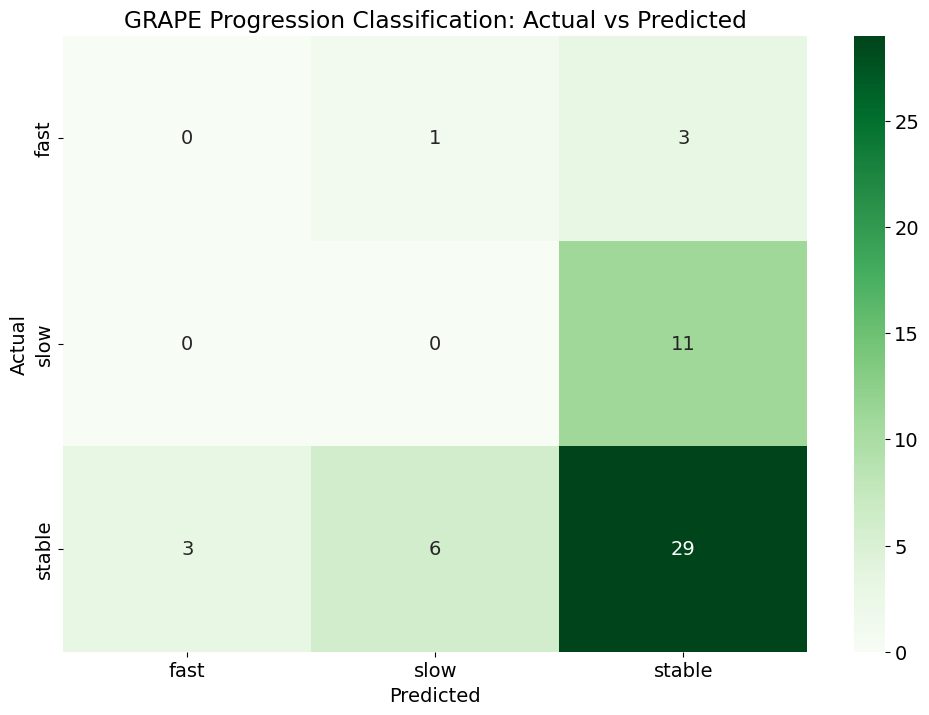

In [ ]:
# 16

# Confusion matrix for GRAPE:

plt.figure(figsize=(12, 8))
sns.heatmap(
    confusion_matrix(grape_y_test, grape_pred),
    annot=True, fmt="d", cmap="Greens",
    xticklabels=clf_grape.classes_,
    yticklabels=clf_grape.classes_
)
plt.title("GRAPE Progression Classification: Actual vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<Figure size 1200x800 with 0 Axes>

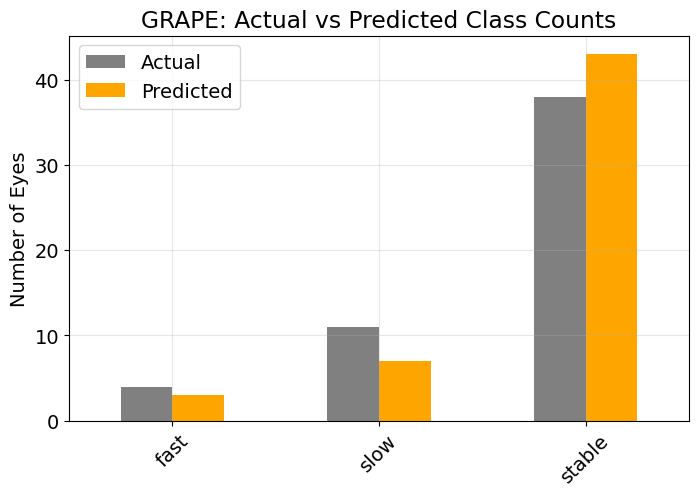

In [ ]:

# 17

plt.figure(figsize=(12, 8))

# Count the number of actual and predicted labels:

grape_actual_counts = grape_y_test.value_counts().sort_index()
grape_pred_counts = pd.Series(grape_pred).value_counts().sort_index()

# Combine into a dataframe for plotting:

df_grape_counts = pd.DataFrame({
    "Actual": grape_actual_counts,
    "Predicted": grape_pred_counts
})

# Plotting: 

df_grape_counts.plot(kind="bar", figsize=(8,5), color=["gray","orange"])

plt.title("GRAPE: Actual vs Predicted Class Counts")
plt.ylabel("Number of Eyes")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

plt.show()


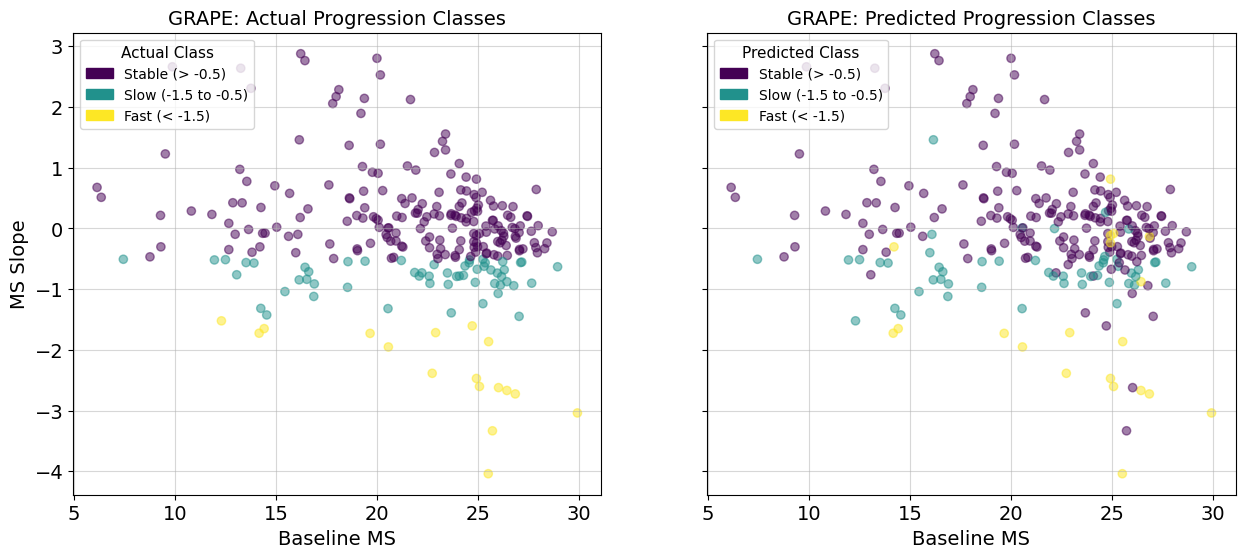

In [ ]:
# 18

if "predicted_class" not in grape_slopes_df.columns:
    
    print("Adding predicted_class to grape_slopes_df.")

    # Predict using GRAPE classifier
    
    grape_slopes_df["predicted_class"] = clf_grape.predict(grape_slopes_df[["baseline_MS"]])

class_to_val = {"stable": 0.0, "slow": 0.5, "fast": 1.0}

# Colors from viridis colormap

legend_colors = {

    "stable": plt.cm.viridis(0.0),
    "slow": plt.cm.viridis(0.5),
    "fast": plt.cm.viridis(1.0),
}

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

# GRAPE Actual Classes:

axes[0].scatter(
    grape_slopes_df["baseline_MS"],
    grape_slopes_df["MS_slope"],
    c=grape_slopes_df["progression_class"].map(class_to_val),
    cmap="viridis",
    alpha=0.5,
)

axes[0].set_title("GRAPE: Actual Progression Classes", fontsize=14)
axes[0].set_xlabel("Baseline MS")
axes[0].set_ylabel("MS Slope")
axes[0].grid(alpha=0.5)

# Legend:

actual_legend = [
    mpatches.Patch(color=legend_colors["stable"], label="Stable (> -0.5)"),
    mpatches.Patch(color=legend_colors["slow"], label="Slow (-1.5 to -0.5)"),
    mpatches.Patch(color=legend_colors["fast"], label="Fast (< -1.5)"),
]
axes[0].legend(
    handles=actual_legend,
    title="Actual Class",
    loc="upper left",
    fontsize=10,
    title_fontsize=11,
)


# GRAPE Predicted Classes:

axes[1].scatter(
    grape_slopes_df["baseline_MS"],
    grape_slopes_df["MS_slope"],
    c=grape_slopes_df["predicted_class"].map(class_to_val),
    cmap="viridis",
    alpha=0.5,
)

axes[1].set_title("GRAPE: Predicted Progression Classes", fontsize=14)
axes[1].set_xlabel("Baseline MS")

axes[1].grid(alpha=0.5)

# Legend 

pred_legend = [
    mpatches.Patch(color=legend_colors["stable"], label="Stable (> -0.5)"),
    mpatches.Patch(color=legend_colors["slow"], label="Slow (-1.5 to -0.5)"),
    mpatches.Patch(color=legend_colors["fast"], label="Fast (< -1.5)"),
]
axes[1].legend(
    handles=pred_legend,
    title="Predicted Class",
    loc="upper left",
    fontsize=10,
    title_fontsize=11,
)

plt.show()
